# Dynamic Mode Decomposition (DMD)
### *~1 year of 6-hourly data of global windspeeds from ERA5*

In [ ]:
from ipyparallel import Client
rc = Client(profile="default")
rc.ids

if len(rc.ids) == 0:
    print("No engines found")
else:
    print(f"{len(rc.ids)} engines found")

In [ ]:
%%px
import heat as ht

## Load the data from `netcdf` and stack them 

In [ ]:
%%px
u = ht.load("/projects/HPDAGrundlagensoftware-Heat/Testdata/ERA5/10m_wind_2024_every6hours.nc", "u10", device="cpu", split=0)
v = ht.load("/projects/HPDAGrundlagensoftware-Heat/Testdata/ERA5/10m_wind_2024_every6hours.nc", "v10", device="cpu", split=0)
u.shape

(1464, 721, 1440)

In [ ]:
%%px
n_timesteps, n_lon, n_lat = u.shape

In [ ]:
%%px
w = ht.stack([u,v],axis=-1)
w.shape

(1464, 721, 1440, 2)

## Compute standard deviation over time and plot 

In [ ]:
%%px
w_std = ht.std(ht.norm(w,axis=-1), axis=0)
w_std.shape

(721, 1440)

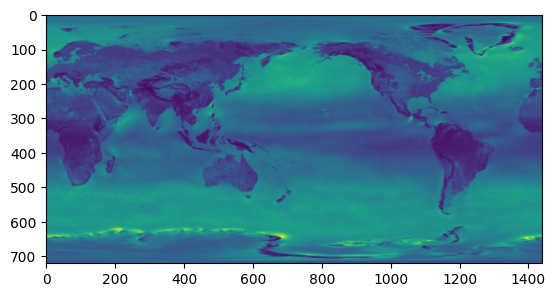

In [ ]:
%%px
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(w_std.numpy())
plt.show()

## Reshape and resplit 

In [ ]:
%%px
w = ht.reshape(w, (n_timesteps, n_lon * n_lat * 2)).T 
w.shape, w.split 

((2076480, 1464), None)

In [ ]:
%%px
w.resplit_(0) 
w.split

0

## Explore low-rank structure 

In [ ]:
%%px
from heat.decomposition import PCA 
pca = PCA(svd_solver="full") 
pca.fit(w) 

PCA({
    "n_components": null,
    "copy": true,
    "whiten": false,
    "svd_solver": "full",
    "tol": null,
    "iterated_power": 0,
    "n_oversamples": 10,
    "power_iteration_normalizer": "qr",
    "random_state": null
})

In [ ]:
%%px
ht.norm(pca.singular_values_[1000:])/ht.norm(pca.singular_values_)

DNDarray(0.1008, dtype=ht.float32, device=cpu:0, split=None)

# Dynamic Mode Decomposition (DMD)

In [ ]:
%%px
from heat.decomposition import DMD 
dmd = DMD(svd_solver="full", svd_rank=1000) 
dmd.fit(w) 

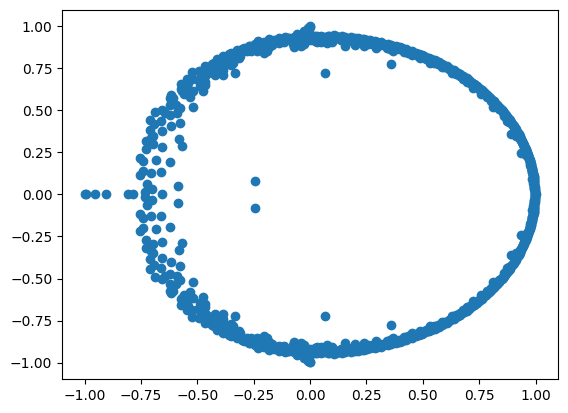

In [ ]:
%%px
dmd.rom_eigenvalues_
re,im = dmd.rom_eigenvalues_.numpy().real, dmd.rom_eigenvalues_.numpy().imag
plt.figure()
plt.scatter(re,im)
plt.show()

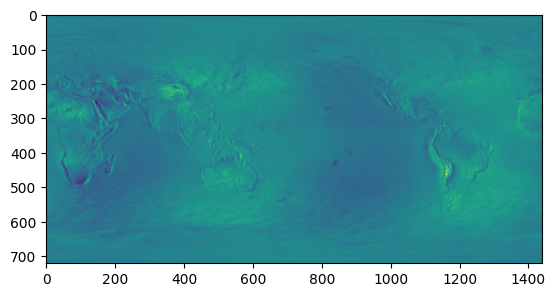

In [ ]:
%%px
first_mode_u_re = ht.real(dmd.dmdmodes_[:,0].reshape(n_lon,n_lat,2)[:,:,0])

plt.figure()
plt.imshow(first_mode_u_re.numpy())
plt.show()